## Time-series based analysis of Earthquake Risk Factors

### Part 6: Time-series analysis on original time-series using multi-variate time-series analysis.

Importing the required libraries:

In [45]:
import numpy as np
import pandas as pd
from math import sqrt

import pickle
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#statsmodel
from statsmodels.tsa.stattools import adfuller


## for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Import VAR
from statsmodels.tsa.api import VAR

### Importing the saved clean time-series earthquake data

In [4]:
file_path = "../datasets/" + "combined_eq_california" + "_timeseries" + ".csv"

df_eq = pd.read_csv(file_path)

df_eq = df_eq[["time", "mag", "sig", "longitude", "latitude", "depth"]]

df_eq["time"] = pd.to_datetime(df_eq["time"])
df_eq["timestamps"] = df_eq["time"]
# df_eq.set_index('time', inplace=True)


df_eq

,time,mag,sig,longitude,latitude,depth,timestamps
0,1970-01-02 10:45:20.570,3.14,152,-119.695667,34.206000,6.000000,1970-01-02 10:45:20.570
1,1970-01-02 21:47:53.740,2.61,105,-117.733667,35.735167,1.650000,1970-01-02 21:47:53.740
2,1970-01-03 02:51:58.400,4.00,246,-122.088000,37.298000,6.274206,1970-01-03 02:51:58.400
3,1970-01-03 19:48:40.840,3.16,154,-116.830500,33.960500,6.000000,1970-01-03 19:48:40.840
4,1970-01-04 02:27:15.700,2.74,116,-116.843333,34.333500,6.000000,1970-01-04 02:27:15.700
...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.970000,2020-10-01 15:00:48.340
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.110000,2020-10-01 15:10:23.760
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.650000,2020-10-01 15:12:42.120
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.290000,2020-10-01 15:21:41.480


In [5]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 16.7 MB


## Important: need to drop repetitive rows (10 rows). There were some overlaps in original data.

In [6]:
df_eq[df_eq.duplicated('timestamps')]

,time,mag,sig,longitude,latitude,depth,timestamps


In [7]:
# Dropping rows
df_eq = df_eq.drop_duplicates(subset=['timestamps'])

df_eq["timestamps"].diff().describe()

count                       313331
mean     0 days 01:25:11.019876935
std      0 days 02:33:43.027017800
min         0 days 00:00:00.009000
25%         0 days 00:08:25.260000
50%         0 days 00:36:55.740000
75%         0 days 01:45:43.790000
max         8 days 04:01:06.380000
Name: timestamps, dtype: object

In [8]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 19.1 MB


## Feature engineering

In [9]:
# Number 1: Time intervals between consecutive earthquakes.
df_eq["time_diff"] = df_eq["timestamps"].diff()

df_eq["time_diff_float"] = df_eq["time_diff"].apply(lambda x: x.total_seconds())

#Number 2: the rolling of magnitudes from the last 10 earthquakes

df_eq["mag_roll_10"] = df_eq["mag"].rolling(window=10).mean()

df_eq.dropna(inplace = True)

In [10]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,313323,2.50313,0.510172,2,2.14,2.35,2.7,7.3
sig,313323,101.847,56.3927,62,70,85,112,2910
longitude,313323,-118.583,3.33437,-131.771,-121.236,-118.096,-116.32,-107.001
latitude,313323,37.0011,4.0049,24.007,34.052,36.1962,38.8195,50
depth,313323,6.27424,6.20748,-3.5,2.232,5.385,8.777,257
time_diff,313323,0 days 01:25:09.914685356,0 days 02:33:38.876407841,0 days 00:00:00.009000,0 days 00:08:25.235000,0 days 00:36:55.720000,0 days 01:45:43.478000,8 days 04:01:06.380000
time_diff_float,313323,5109.91,9218.88,0.009,505.235,2215.72,6343.48,705666
mag_roll_10,313323,2.50314,0.226073,2.043,2.354,2.46,2.597,4.826


### 600 days without any recorded earthquakes:

In [11]:
df_eq[df_eq["time_diff_float"] > 86400].shape

(608, 10)

In [12]:
df_eq[df_eq["time_diff_float"] > 86400]

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
18,1970-01-11 13:50:41.420,2.24,77,-118.420167,35.492500,6.00,1970-01-11 13:50:41.420,1 days 02:05:15.740000,93915.74,2.841
37,1970-01-18 00:01:09.770,2.37,86,-117.290500,34.284167,5.81,1970-01-18 00:01:09.770,1 days 09:10:07.190000,119407.19,2.838
38,1970-01-19 07:16:25.380,4.49,310,-115.982000,31.882333,6.00,1970-01-19 07:16:25.380,1 days 07:15:15.610000,112515.61,3.007
42,1970-01-21 11:23:52.610,4.02,249,-115.978833,32.319667,6.00,1970-01-21 11:23:52.610,1 days 00:59:55.410000,89995.41,2.980
44,1970-01-23 16:30:01.120,3.97,242,-116.036833,37.137333,0.30,1970-01-23 16:30:01.120,1 days 13:37:46.280000,135466.28,3.060
...,...,...,...,...,...,...,...,...,...,...
303252,2019-09-02 01:53:55.010,2.41,89,-115.858667,33.902833,2.17,2019-09-02 01:53:55.010,1 days 03:59:44.940000,100784.94,2.321
305041,2020-01-02 00:42:09.750,2.27,79,-118.933500,37.638000,6.18,2020-01-02 00:42:09.750,1 days 02:23:48.590000,95028.59,2.269
305681,2020-03-02 00:31:07.620,2.43,91,-122.212333,40.926667,9.55,2020-03-02 00:31:07.620,1 days 02:11:00.190000,94260.19,2.484
309776,2020-06-02 00:30:49.240,2.01,62,-115.650500,33.154000,3.37,2020-06-02 00:30:49.240,1 days 01:25:13.490000,91513.49,2.450


In [13]:
min_date = df_eq["time"].min().date()

min_date

datetime.date(1970, 1, 7)

In [14]:
max_date = df_eq["time"].max().date()

max_date

datetime.date(2020, 10, 1)

In [15]:
type(df_eq["time"].max().date())

datetime.date

In [16]:
#https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python

start_date = min_date

number_of_days = (max_date - min_date).days
print("number_of_days", number_of_days)
date_list = []
for day in range(number_of_days):
  a_date = (start_date + datetime.timedelta(days = day))
  date_list.append(a_date)

print(date_list[1], type(date_list[0]))

number_of_days 18530
1970-01-08 <class 'datetime.date'>


In [17]:
df_eq

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
9,1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263
10,1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189
11,1970-01-07 18:04:50.000,3.07,145,-120.980667,34.607000,6.00,1970-01-07 18:04:50.000,0 days 14:39:23.890000,52763.89,3.235
12,1970-01-08 02:16:41.350,2.75,116,-117.139833,34.307833,6.00,1970-01-08 02:16:41.350,0 days 08:11:51.350000,29511.35,3.110
13,1970-01-08 17:00:33.860,3.70,211,-121.565833,34.574333,6.00,1970-01-08 17:00:33.860,0 days 14:43:52.510000,53032.51,3.164
...,...,...,...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.97,2020-10-01 15:00:48.340,0 days 00:11:30.200000,690.20,2.536
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.11,2020-10-01 15:10:23.760,0 days 00:09:35.420000,575.42,2.540
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.65,2020-10-01 15:12:42.120,0 days 00:02:18.360000,138.36,2.437
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.29,2020-10-01 15:21:41.480,0 days 00:08:59.360000,539.36,2.488


In [18]:
df_eq.set_index('time', inplace=True)

In [19]:
df_daily = pd.DataFrame() 
# AS is year-start frequency
df_daily['event_count'] = df_eq.mag.resample('D').count() #How many events happened 
df_daily['mag_max'] = df_eq.mag.resample('D').max() # What is the max of events
df_daily['mag_mean'] = df_eq.mag.resample('D').mean() #What is the mean of values for that particular day
df_daily['mag_sum'] = df_eq.mag.resample('D').sum() # What is the sum of moments
df_daily['mag_scatter'] = (df_eq.mag.resample('D').std()) # What is the scatter of event magnitudes
df_daily["mag_roll_10"] = df_daily["mag_mean"].rolling(window=10).mean()


df_daily['longitude_mean'] = df_eq.longitude.resample('D').mean() #Mean location of events 
df_daily['longitude_std'] = df_eq.longitude.resample('D').std() #Std location of events 

df_daily['latitude_mean'] = df_eq.latitude.resample('D').mean() #Mean location of events 
df_daily['latitude_std'] = df_eq.latitude.resample('D').std() #Std location of events 

df_daily['depth_mean'] = df_eq.depth.resample('D').mean() #Mean location of events 
df_daily['depth_std'] = df_eq.depth.resample('D').std() #Std location of events 

df_daily['time_diff_float_mean'] = df_eq.time_diff_float.resample('D').mean() #Event spacing 
df_daily['time_diff_float_std'] = df_eq.time_diff_float.resample('D').std() #Std location of events 


df_daily

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,mag_roll_10,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,,
1970-01-07,3,3.31,2.926667,8.78,0.471628,NaN,-118.150056,2.617310,34.005444,2.176113,5.886667,0.196299,23733.110000,25179.320539
1970-01-08,2,3.70,3.225000,6.45,0.671751,NaN,-119.352833,3.129655,34.441083,0.188444,6.000000,0.000000,41271.930000,16631.971737
1970-01-09,1,2.44,2.440000,2.44,NaN,NaN,-118.610167,NaN,35.397000,NaN,6.000000,NaN,43656.790000,NaN
1970-01-10,3,3.03,2.833333,8.50,0.290230,NaN,-117.889444,1.413732,38.679556,7.140646,4.788667,2.893839,36745.010000,33802.932830
1970-01-11,6,3.37,2.566667,15.40,0.564151,NaN,-119.576389,1.766064,35.231611,0.419287,5.928333,0.404496,19058.731667,37098.376200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,14,3.42,2.392143,33.49,0.439496,2.489418,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,14,3.48,2.337857,32.73,0.407340,2.471204,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,22,3.90,2.612273,57.47,0.494579,2.491639,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


In [20]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18531 entries, 1970-01-07 to 2020-10-01
Freq: D
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_count           18531 non-null  int64  
 1   mag_max               18094 non-null  float64
 2   mag_mean              18094 non-null  float64
 3   mag_sum               18531 non-null  float64
 4   mag_scatter           17707 non-null  float64
 5   mag_roll_10           15494 non-null  float64
 6   longitude_mean        18094 non-null  float64
 7   longitude_std         17707 non-null  float64
 8   latitude_mean         18094 non-null  float64
 9   latitude_std          17707 non-null  float64
 10  depth_mean            18094 non-null  float64
 11  depth_std             17707 non-null  float64
 12  time_diff_float_mean  18094 non-null  float64
 13  time_diff_float_std   17707 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 2.1 MB

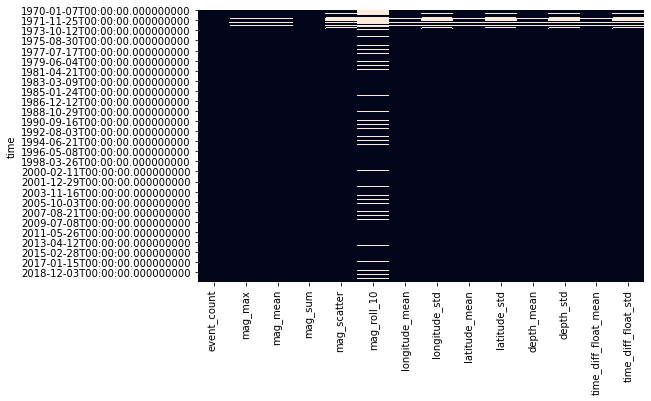

In [21]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily.isnull(), cbar=False)

In [22]:
df_daily_clean = df_daily[df_daily.index > "1972-01-01"]

df_daily_clean.drop(columns = ["mag_roll_10"], inplace = True)

df_daily_clean

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2,2.90,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.193500,10.173145,64877.640000,90530.909480
1972-01-03,1,4.60,4.600000,4.60,NaN,-112.170000,NaN,38.650000,NaN,7.000000,NaN,105546.310000,NaN
1972-01-04,1,2.30,2.300000,2.30,NaN,-123.153333,NaN,47.200833,NaN,15.401000,NaN,81088.790000,NaN
1972-01-05,0,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-01-06,3,3.54,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.980000,3.266298,66695.046667,73587.754649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,14,3.42,2.392143,33.49,0.439496,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,14,3.48,2.337857,32.73,0.407340,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,22,3.90,2.612273,57.47,0.494579,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


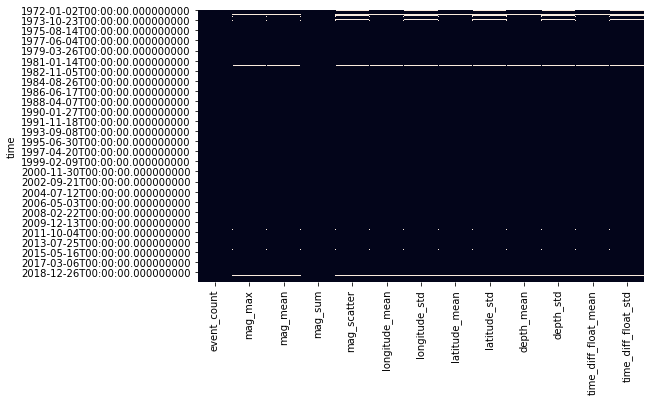

In [23]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily_clean.isnull(), cbar=False)

In [24]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_count           17806 non-null  int64  
 1   mag_max               17498 non-null  float64
 2   mag_mean              17498 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17308 non-null  float64
 5   longitude_mean        17498 non-null  float64
 6   longitude_std         17308 non-null  float64
 7   latitude_mean         17498 non-null  float64
 8   latitude_std          17308 non-null  float64
 9   depth_mean            17498 non-null  float64
 10  depth_std             17308 non-null  float64
 11  time_diff_float_mean  17498 non-null  float64
 12  time_diff_float_std   17308 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


## Imputing the missing values:

In [25]:
#Source: https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
df_daily_clean.interpolate('time', inplace = True)
df_daily_clean

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2,2.90,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.193500,10.173145,64877.640000,90530.909480
1972-01-03,1,4.60,4.600000,4.60,0.555611,-112.170000,3.207186,38.650000,7.310155,7.000000,8.446433,105546.310000,86295.120772
1972-01-04,1,2.30,2.300000,2.30,0.545537,-123.153333,2.305493,47.200833,5.157218,15.401000,6.719721,81088.790000,82059.332064
1972-01-05,0,2.92,2.638333,0.00,0.535463,-120.584667,1.403799,41.014194,3.004280,8.690500,4.993010,73891.918333,77823.543356
1972-01-06,3,3.54,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.980000,3.266298,66695.046667,73587.754649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,14,3.42,2.392143,33.49,0.439496,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,14,3.48,2.337857,32.73,0.407340,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,22,3.90,2.612273,57.47,0.494579,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


In [26]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_count           17806 non-null  int64  
 1   mag_max               17806 non-null  float64
 2   mag_mean              17806 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17806 non-null  float64
 5   longitude_mean        17806 non-null  float64
 6   longitude_std         17806 non-null  float64
 7   latitude_mean         17806 non-null  float64
 8   latitude_std          17806 non-null  float64
 9   depth_mean            17806 non-null  float64
 10  depth_std             17806 non-null  float64
 11  time_diff_float_mean  17806 non-null  float64
 12  time_diff_float_std   17806 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


### Putting back the dataframe into original DataFrame aamd do stuff

In [27]:
df_eq = df_daily_clean
df_eq.shape

(17806, 13)

### Labeling the large earthquakes (M>6). This helps slicing the time-series for later specific purposes

In [28]:
## Large earthquakes labeling:
label = []
cnt = 0
for i, mag in enumerate(df_eq["mag_max"]):
    if (mag>5.5):
        cnt = cnt + 1
        label.append(int(cnt))
    else:
        label.append(0)

df_eq["large_eq_label"] = label

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [29]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
event_count,17806.0,17.500955,30.741280,0.000000,9.000000,13.000000,19.000000,1800.000000
mag_max,17806.0,3.531407,0.703016,2.000000,3.010000,3.400000,3.920000,7.300000
mag_mean,17806.0,2.498802,0.215661,2.000000,2.368457,2.460445,2.576364,5.800000
mag_sum,17806.0,43.760240,81.277989,0.000000,22.770000,32.810000,46.187500,5075.860000
mag_scatter,17806.0,0.449793,0.196728,0.000000,0.316971,0.413549,0.544998,1.994041
longitude_mean,17806.0,-118.902148,1.504638,-127.923500,-119.875837,-118.906986,-117.957002,-108.287050
longitude_std,17806.0,3.148797,1.048462,0.001532,2.480551,3.099534,3.781318,11.074117
latitude_mean,17806.0,37.382431,2.019502,27.540000,36.090607,37.186525,38.466116,49.071000
latitude_std,17806.0,3.661762,1.397388,0.001532,2.668346,3.647200,4.566034,16.128139
depth_mean,17806.0,6.757191,2.791850,-1.115000,5.041752,6.391071,8.067750,48.270000


In [30]:
# df_eq["time_diff_float"] = np.datetime64(df_eq["time_diff"][0]).astype(float)
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_count           17806 non-null  int64  
 1   mag_max               17806 non-null  float64
 2   mag_mean              17806 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17806 non-null  float64
 5   longitude_mean        17806 non-null  float64
 6   longitude_std         17806 non-null  float64
 7   latitude_mean         17806 non-null  float64
 8   latitude_std          17806 non-null  float64
 9   depth_mean            17806 non-null  float64
 10  depth_std             17806 non-null  float64
 11  time_diff_float_mean  17806 non-null  float64
 12  time_diff_float_std   17806 non-null  float64
 13  large_eq_label        17806 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.0 MB

### Checking the entiretity of the time-series

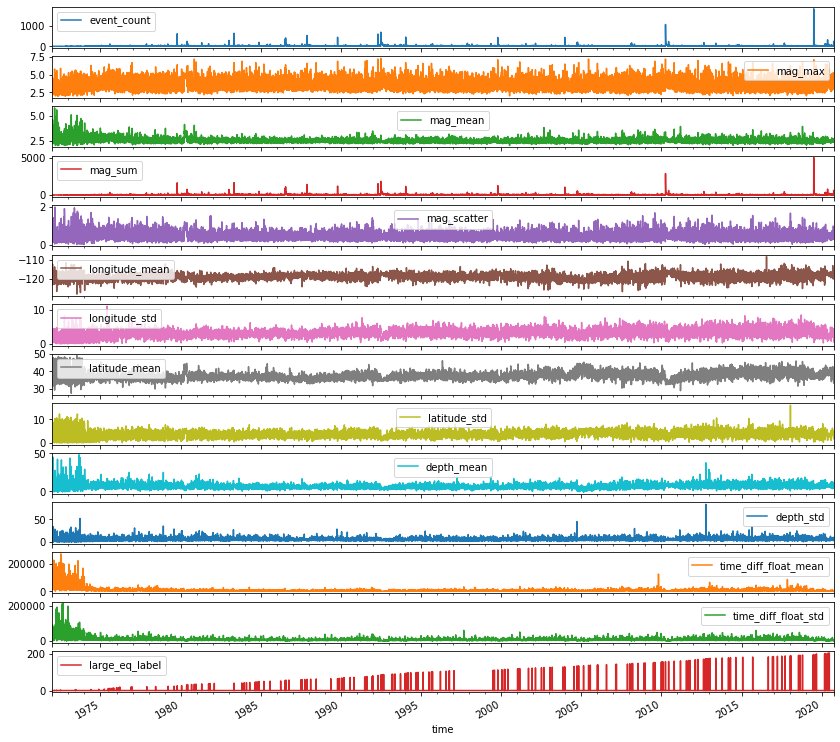

In [31]:
df_eq.plot(subplots=True,figsize=(14,14));

### Is there any collinearity between parameters:

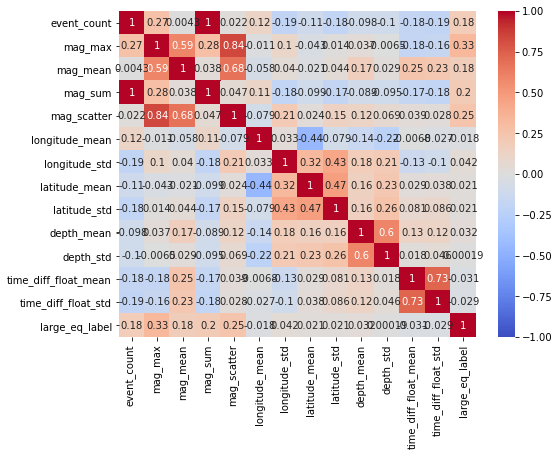

In [32]:
df_corr = df_eq.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr,
        vmin=-1,
        cmap='coolwarm',
        annot=True);
# plt.savefig("../plots/Loma_prieta_EDA_corr_plots.png")

### Figure discussion: 
---
Mag and sig are almost correlated, meaning that sig which was based on judgement and phsycial mag are corrleated. On the other hand, mag and sig coud happen on all depoths and longitude/latitudes.<br>
Longitude and latitude are negatively correlated meaning that the lineation going from NW-SE happening.

In [39]:
df_eq.head(2)

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std,large_eq_label
time,,,,,,,,,,,,,,
1972-01-02,2,2.9,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480,0
1972-01-03,1,4.6,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772,0


# VAR modeling

### Model Fitting Process
1. Confirm stationarity of the data.
2. Train/test split.
3. Determine correct lag order $p$.
4. Fit model.
5. Generate forecasts.
6. Evaluate model and forecasts (if possible).

#### 1. Confirm stationarity of the data.
Vector autoregressive models require stationarity in order for us to fit them!

In [40]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [43]:
# Run ADF test on the original Real GDP data.
interpret_dftest(adfuller(df_eq['mag_max']))

Test Statistic   -1.417529e+01
p-value           1.970967e-26
Lag Used          3.800000e+01
dtype: float64

# Stationary!

In [46]:
# What am I missing?

train, test = train_test_split(df_eq,
                               test_size = 0.25,
                               shuffle = False)

In [47]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train)

In [52]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(maxlags=60, # what is the largest possible value of p?
                     ic='aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [53]:
# What is the order of our autoregressive model? 
ts_model.k_ar

57

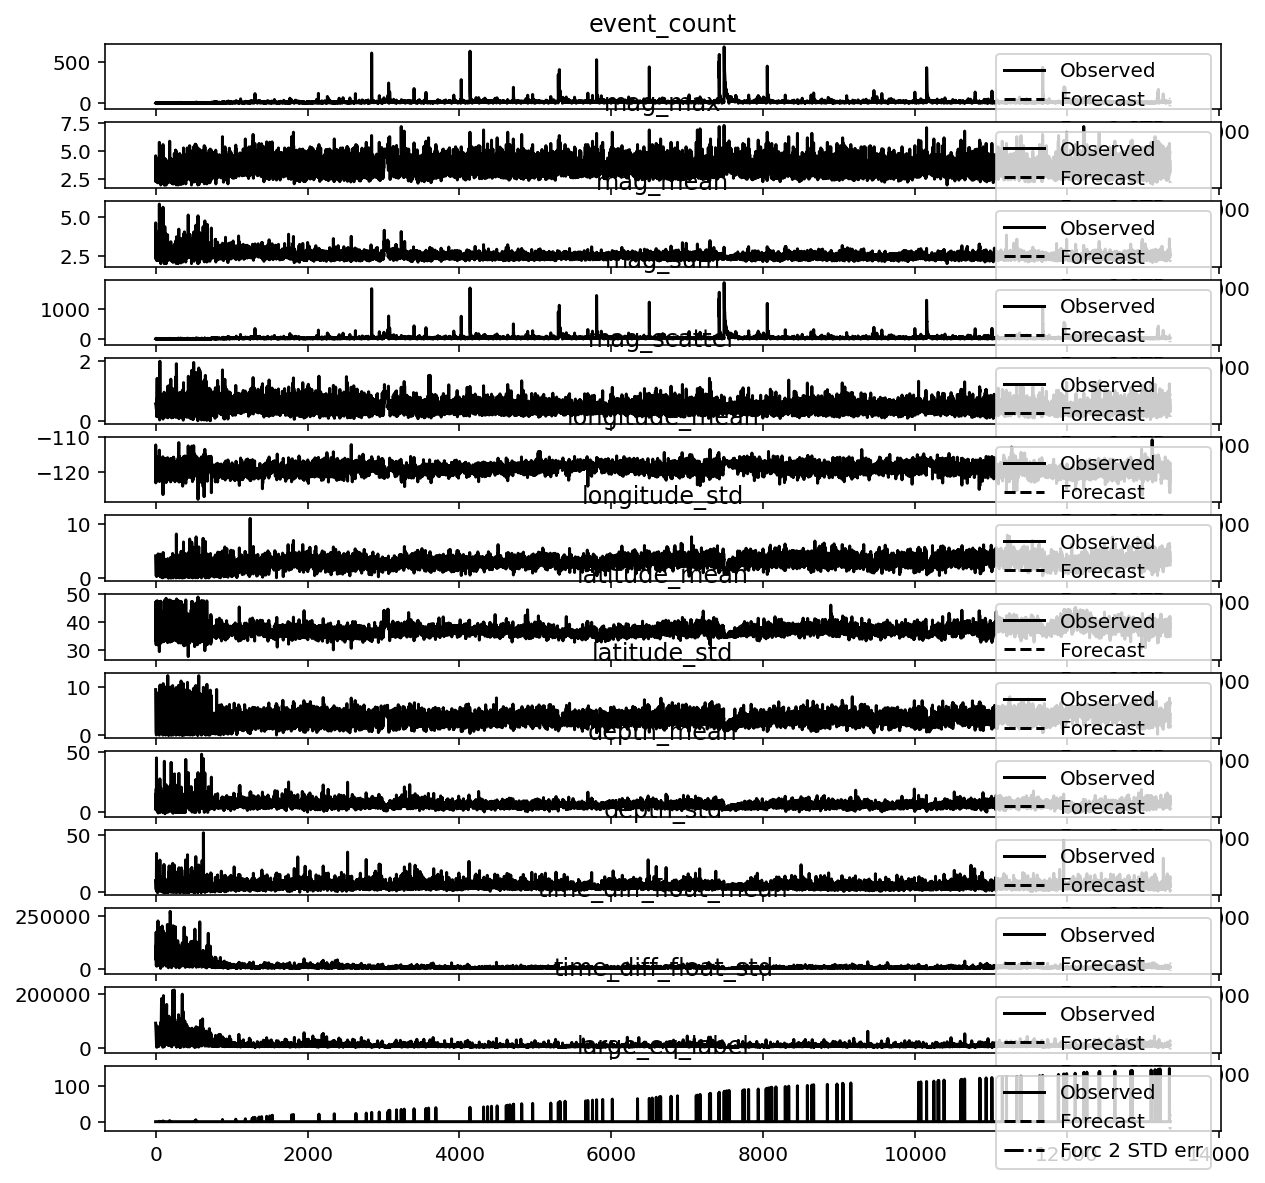

In [55]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

#### 6. Evaluate model (and forecasts, if possible).

In [56]:
# We'll use MSE
from sklearn.metrics import mean_squared_error

In [57]:
# Save forecasted values
forecast = ts_model.forecast(train.values, len(test))

In [58]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the event_count data is: 1614.527
The test MSE on the mag_max data is: 0.5135
The test MSE on the mag_mean data is: 0.0313
The test MSE on the mag_sum data is: 11815.1416
The test MSE on the mag_scatter data is: 0.0398
The test MSE on the longitude_mean data is: 3.0395
The test MSE on the longitude_std data is: 1.4548
The test MSE on the latitude_mean data is: 5.4124
The test MSE on the latitude_std data is: 2.009
The test MSE on the depth_mean data is: 9.8385
The test MSE on the depth_std data is: 10.1028
The test MSE on the time_diff_float_mean data is: 33508875.5838
The test MSE on the time_diff_float_std data is: 30961078.2174
The test MSE on the large_eq_label data is: 391.9821


In [59]:
df_eq.head()

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std,large_eq_label
time,,,,,,,,,,,,,,
1972-01-02,2,2.90,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.1935,10.173145,64877.640000,90530.909480,0
1972-01-03,1,4.60,4.600000,4.60,0.555611,-112.170000,3.207186,38.650000,7.310155,7.0000,8.446433,105546.310000,86295.120772,0
1972-01-04,1,2.30,2.300000,2.30,0.545537,-123.153333,2.305493,47.200833,5.157218,15.4010,6.719721,81088.790000,82059.332064,0
1972-01-05,0,2.92,2.638333,0.00,0.535463,-120.584667,1.403799,41.014194,3.004280,8.6905,4.993010,73891.918333,77823.543356,0
1972-01-06,3,3.54,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.9800,3.266298,66695.046667,73587.754649,0


Text(0.5, 1.0, 'Maximum daily amplitude time-series ')

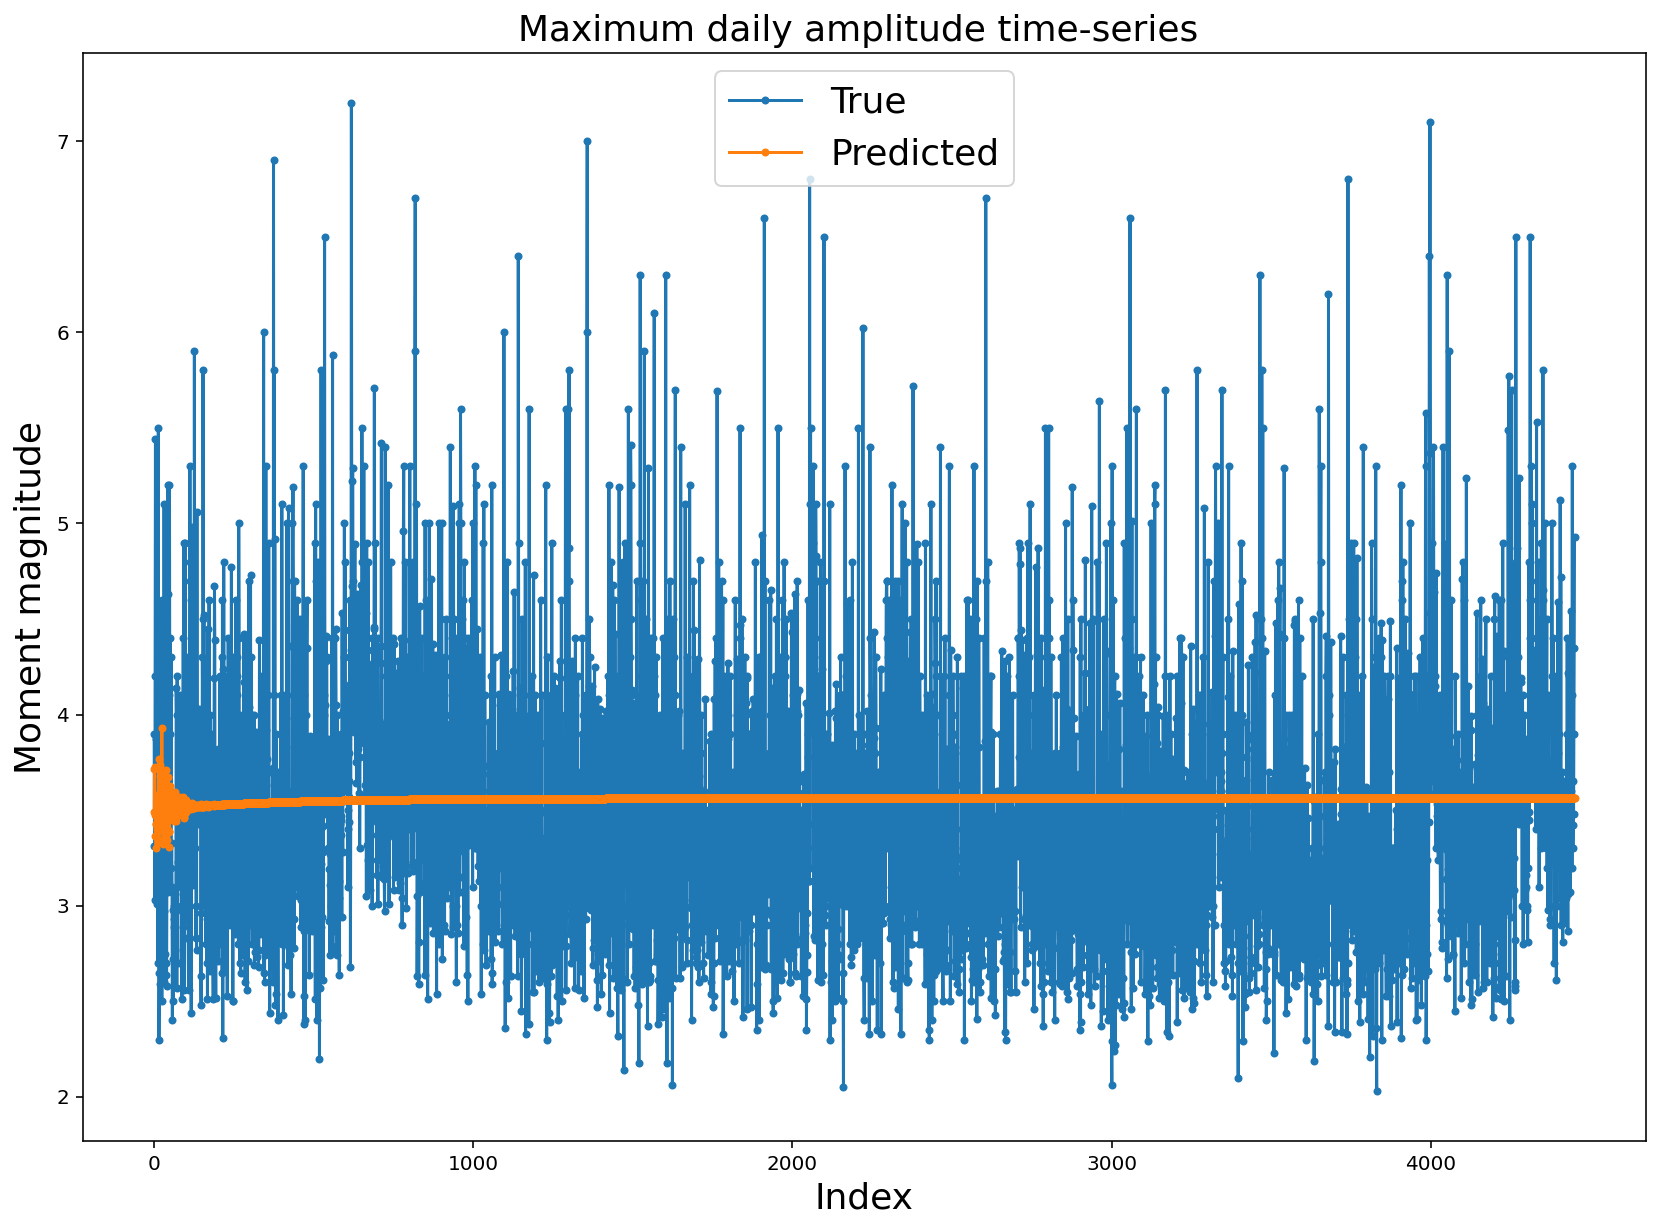

In [68]:
plt.figure(figsize = (14,10))
plt.plot(test.values[:, 1], marker = '.', label = "True")
plt.plot(forecast[:, 1], marker = '.', label = "Predicted")
# plt.xlim(12_000, 18_000)
plt.legend(fontsize=18)
plt.xlabel("Index", fontsize=18)
plt.ylabel("Moment magnitude", fontsize=18)
plt.title("Maximum daily amplitude time-series ", fontsize=18)

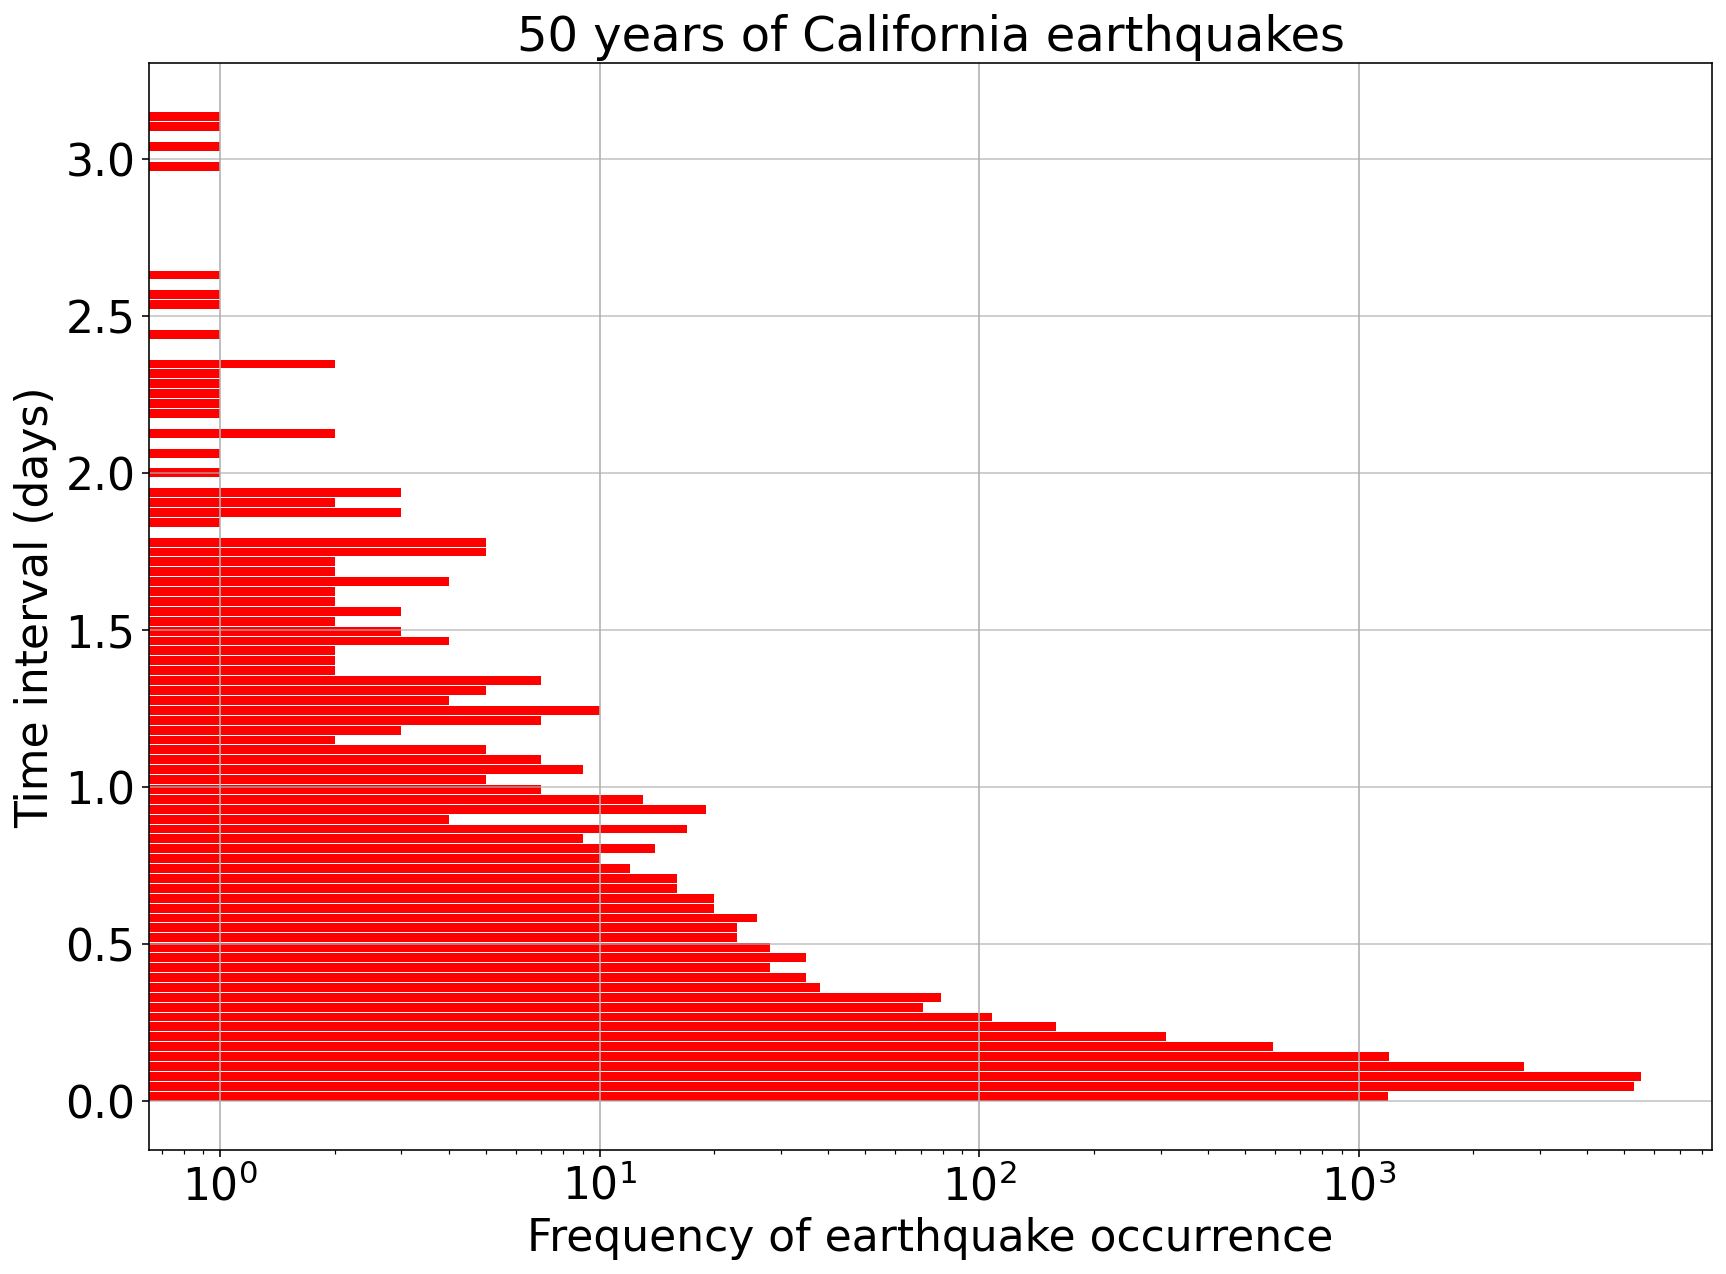

In [36]:
df_eq_plot = df_eq.copy()
df_eq_plot["time_days"] = (np.array(df_eq_plot["time_diff_float_mean"])/86_400)


%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (14, 10));




df_eq_plot["time_days"].plot.hist(grid=True, bins=100, rwidth=0.9,orientation="horizontal",
                   color='red')

plt.title('50 years of California earthquakes',fontsize = 24)
plt.ylabel('Time interval (days)',fontsize = 22)
plt.xlabel('Frequency of earthquake occurrence',fontsize = 22)

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

# plt.ylim(0, 6)
plt.grid(axis='y', alpha=0.75)

plt.xscale('log')


plt.savefig('../plots/Medium_fig_2.png')

#### Dropping the unnecessary columns for time-series modeling:

In [37]:
df_eq.head(2)

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std,large_eq_label
time,,,,,,,,,,,,,,
1972-01-02,2,2.9,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480,0
1972-01-03,1,4.6,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772,0


Split the data into train/test with 10% of data as test dataset

In [93]:
df_eq_model = df_eq.drop(columns = ["large_eq_label"])

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(16025, 13) (1781, 13)


In [94]:
train.head(2)

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2,2.9,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480
1972-01-03,1,4.6,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772


In [95]:
test.head(2)

,event_count,mag_max,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
2015-11-17,12,2.79,2.366667,28.40,0.238874,-118.510814,4.431423,38.609539,3.788335,9.164167,7.158176,7044.566833,7393.333314
2015-11-18,13,3.39,2.583077,33.58,0.466751,-119.214556,4.975327,39.655182,4.490104,5.844615,5.725807,6791.768462,6488.976717


Scaling the data:

In [96]:
f_columns = ['event_count', 'mag_mean', 'mag_sum', 'mag_scatter',
       'longitude_mean', 'longitude_std', 'latitude_mean', 'latitude_std',
       'depth_mean', 'depth_std', 'time_diff_float_mean',
       'time_diff_float_std']

f_transformer = RobustScaler()
mag_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
mag_transformer = mag_transformer.fit(train[["mag_max"]])

In [97]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [98]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["mag_max"] = mag_transformer.transform(train[["mag_max"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["mag_max"] = mag_transformer.transform(test[["mag_max"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us